In [1]:
# Created by Deniz Karakay at 17.04.2023
# Filename: question_3.py

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import time
from torch.utils.data import SubsetRandomSampler
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from Q3 import models as my_models
from utils.utils import visualizeWeights

# Hyper-parameters
EPOCH_SIZE = 15
BATCH_SIZE = 50
TRAIN_COUNT = 2

# I tested and saw that CPU is faster than GPU on M1 Pro

# MPS for GPU support on M1
# device = torch.device("mps")

# CPU
device = torch.device("cpu")
print(device)

init_time = time.time()

# Transformations
transform = transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    torchvision.transforms.Grayscale()
])

# Load data
train_data = torchvision.datasets.CIFAR10('data/', train=True, download=True, transform=transform)

# Print image size and label of first image in dataset (should be 32x32 and 6)
img, label = train_data[0]
print("Sample image size: ", img.size())

# Split data into training and validation
train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Load test data
test_data = torchvision.datasets.CIFAR10('data/', train=False, transform=transform)

print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(valid_data)}")
print(f"Test data size: {len(test_data)}")

valid_generator = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

my_models = {'mlp1': my_models.MLP1(1024, 32, 10).to(device), 'mlp2': my_models.MLP2(1024, 32, 64, 10).to(device)}

for model_name, model in my_models.items():
    if model_name == 'mlp1':
        continue

    print(f"Training {model_name}...")

    model_init_time = time.time()

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    best_performance = 0
    best_weights = None

    train_acc_history_total = []
    train_loss_history_total = []
    valid_acc_history_total = []
    test_acc_history_total = []

    for tc in range(TRAIN_COUNT):

        # Initialize lists for training and validation accuracy and loss
        train_acc_history = []
        train_loss_history = []
        valid_acc_history = []
        test_acc_history = []

        for epoch in range(EPOCH_SIZE):
            # Train the model
            start_time = time.time()
            train_generator = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
            total_step = len(train_generator)

            for i, data in enumerate(train_generator):
                model.train()
                inputs, labels = data
                train_inputs, train_labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward + backward + optimize
                train_outputs = model(train_inputs)
                loss = criterion(train_outputs, train_labels)

                loss.backward()
                optimizer.step()

                if i % 10 == 9:
                    model.eval()
                    # Compute training accuracy
                    _, train_pred = torch.max(train_outputs, 1)
                    train_size = train_labels.size(0)
                    train_corrects = torch.sum(train_pred == train_labels.data)

                    train_acc = train_corrects / train_size

                    # Save training loss
                    train_loss = loss.item()

                    valid_correct = 0
                    valid_total = 0
                    with torch.no_grad():
                        for data in valid_generator:
                            inputs, labels = data
                            valid_inputs, valid_labels = inputs.to(device), labels.to(device)

                            # Compute the outputs and predictions
                            valid_outputs = model(valid_inputs)
                            _, valid_predicted = torch.max(valid_outputs.data, 1)

                            # Track the statistics
                            valid_total += valid_labels.size(0)
                            valid_correct += (valid_predicted == valid_labels).sum().item()

                    valid_acc = valid_correct / valid_total

                    valid_acc_history.append(valid_acc)
                    train_acc_history.append(train_acc)
                    train_loss_history.append(train_loss)
                    # print(f'Train accuracy: {train_acc:.3f}')

            epoch_time = time.time() - start_time
            print(
                f"Epoch [{epoch + 1}/{EPOCH_SIZE}], Epoch Time: {epoch_time:.4f} s, Validation Accuracy: {valid_acc:.4f}")

        train_acc_history_total.append(train_acc_history)
        train_loss_history_total.append(train_loss_history)
        valid_acc_history_total.append(valid_acc_history)

        # Evaluate the model on test set
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            test_generator = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
            model.eval()
            for data in test_generator:
                inputs, labels = data
                test_inputs, test_labels = inputs.to(device), labels.to(device)

                # Compute the outputs and predictions
                test_outputs = model(test_inputs)
                _, test_predicted = torch.max(test_outputs.data, 1)

                # Track the statistics
                test_total += test_labels.size(0)
                test_correct += (test_predicted == test_labels).sum().item()
                test_acc = test_correct / test_total

            # Save best weights
            if test_acc > best_performance:
                best_performance = test_acc
                best_weights = model.fc1.weight.data.cpu().numpy()

            # Save test accuracy
            test_acc_history.append(test_acc)

        took_time = time.time() - model_init_time
        print(f"Training [{tc + 1}/{TRAIN_COUNT}], {took_time:.4f} s, Test Accuracy: {best_performance:.4f}")

        test_acc_history_total.append(test_acc_history)


cpu
Files already downloaded and verified
Sample image size:  torch.Size([1, 32, 32])
Training data size: 45000
Validation data size: 5000
Test data size: 10000
Training mlp2...
Epoch [1/15], Epoch Time: 1.7294 s, Validation Accuracy: 0.3360
Epoch [2/15], Epoch Time: 1.6953 s, Validation Accuracy: 0.3732
Epoch [3/15], Epoch Time: 1.7004 s, Validation Accuracy: 0.3766
Epoch [4/15], Epoch Time: 1.7682 s, Validation Accuracy: 0.3754
Epoch [5/15], Epoch Time: 2.1066 s, Validation Accuracy: 0.3760
Epoch [6/15], Epoch Time: 1.9154 s, Validation Accuracy: 0.3890
Epoch [7/15], Epoch Time: 1.6850 s, Validation Accuracy: 0.3946
Epoch [8/15], Epoch Time: 1.6960 s, Validation Accuracy: 0.3812
Epoch [9/15], Epoch Time: 1.7018 s, Validation Accuracy: 0.3910
Epoch [10/15], Epoch Time: 1.6790 s, Validation Accuracy: 0.3904
Epoch [11/15], Epoch Time: 1.6660 s, Validation Accuracy: 0.3858
Epoch [12/15], Epoch Time: 1.6882 s, Validation Accuracy: 0.3792
Epoch [13/15], Epoch Time: 1.6824 s, Validation Acc

Best performance for mlp2: 0.3918, took 149.8689 s
Best test accuracy: 0.3918
All process for mlp2: 149.8840 s


/Users/sedna/local-dev/METU/EE449/HW1/utils/utils.py:397: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


All process: 154.7298 s


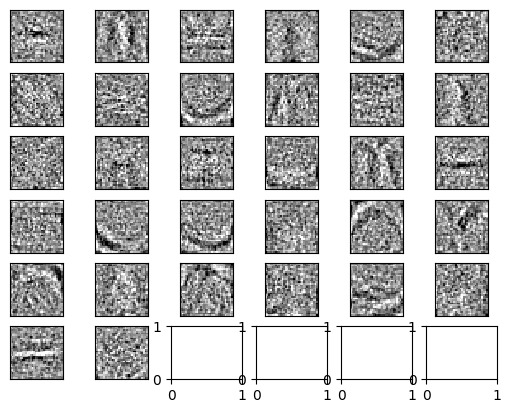

In [2]:

took_time = time.time() - model_init_time
print(f"Best performance for {model_name}: {best_performance:.4f}, took {took_time:.4f} s")

# Average training loss
t = np.array(train_loss_history_total)
average_train_loss = np.mean(t, axis=0)

# Average training accuracy
t = np.array(train_acc_history_total)
average_train_acc = np.mean(t, axis=0)

# Average validation accuracy
t = np.array(valid_acc_history_total)
average_valid_acc = np.mean(t, axis=0)

best_test_acc = np.max(test_acc_history_total)
print(f"Best test accuracy: {best_test_acc:.4f}")

# Save the results
result_dict = {
    'name': model_name,
    'loss_curve': average_train_loss,
    'train_acc_curve': average_train_acc,
    'val_acc_curve': average_valid_acc,
    'test_acc': best_test_acc,
    'weights': best_weights
}

# Save the results to a file
filename = 'results/question_3_' + model_name.replace(' ', '_') + '.pkl'
with open(filename, 'wb') as f:
    pickle.dump(result_dict, f)

took_time = time.time() - model_init_time
print(f"All process for {model_name}: {took_time:.4f} s")

visualizeWeights(best_weights, save_dir='results/',
                 filename='question_3_weights_' + model_name.replace(' ', '_'))

took_time = time.time() - init_time
print(f"All process: {took_time:.4f} s")
